# Ce ntebook sert à regarder l'évolution de l'maplitude de diverses stations proches de la coastline en focntion du temps et de la comparer avec l'évolution de l'amplitude / baz des beams !

In [8]:
import numpy as np
from obspy.clients.fdsn.client import Client
from obspy.core.utcdatetime import UTCDateTime
from typing import List
from time import time
import matplotlib.pyplot as plt
from obspy.signal.spectral_estimation import PPSD
import os
from obspy.geodetics import gps2dist_azimuth
from matplotlib.colorbar import ColorbarBase
from tqdm import tqdm, trange


from basic_functions import *

%matplotlib ipympl


In [9]:
from scipy.signal import butter, filtfilt

def get_daily_amplitudes(net_list, sta_list,day, freqs):
    amplitude_list = np.zeros((len(sta_list),1))
    for i in range(len(sta_list)): #on gère l'ensemble des traces en rstirant al réponse + en les filtrant
        try:
            response = client.get_stations(network=net_list[0],station=sta_list[i],location='*',channel='HHZ,EHZ,BHZ',starttime=day,endtime=day,level='response')
            st = client.get_waveforms(network=net_list[0], station=sta_list[i], location='*', channel='HHZ,EHZ,BHZ',starttime=day, endtime=day+86400, attach_response=True)
            ppsd = PPSD(st[0].stats,metadata=response, ppsd_length=3600, skip_on_gaps=True)
            ppsd.add(st[0])
            try:
                os.mkdir(sta_list[i]) #fait dossier du nom de la station 
            except:
                pass
            ppsd.plot(filename=f'{sta_list[i]}/PPSD_{day.year:02}-{day.month:02}-{day.day:02}.png')
            st[0].remove_response(output='VEL')
            st[0].filter('bandpass', freqmin=freqs[0], freqmax=freqs[1])
            amplitude_list[i] = np.std(st[0].data) #calcule l'amplitude moyenne de la trace en valeur absolue
        except: #si pas pu télécharger les données alors il faut combler le trou, on comble avec un np.nan ! 
            amplitude_list[i] = np.nan
    return amplitude_list


def get_daily_amplitudes_from_dl(net_list, sta_list,day, freqs):
    '''Fonction pour calculer amplitud à partir des data q'on aura dl avec pycorr et qu'on aura cooked pour remove leq eq'''
    #need to convert utc date to julian day to know which year and which 
    amplitude_list = np.zeros((len(sta_list),1))
    b,a = butter(1, [freqs[0],freqs[1]], btype='bandpass', output='ba', fs=20.0)
    year = day.year
    day_file = int((day-UTCDateTime(f'{year}-01-01'))/86400)+1 #à voir si c'est bien le bon jour, pas sûr
    path = f'/summer/faultscan/user/parisnic/m1_internship/parkfield/data_broad/data_20.0hz_cooked/daily/glob/{year}/day_{day_file:03}.h5'
    for i, sta in enumerate(sta_list):
        try:
            st = h5py.File(path,'r')['NC'][f'{sta}.00']['Z'][:]
        except:
            try:
                st = h5py.File(path,'r')['NC'][f'{sta}.02']['Z'][:] #flemme de lui faire chercher à savvoir si telle station est telle loc
            except:
                st = np.nan
        try:    
            st_filtered = filtfilt(b,a,st)
            amplitude_list[i] = np.mean(np.abs(st_filtered)) #calcule l'average du carré de la trace -> bien pour comaprer avec beam POWA 
        except: #si pas pu télécharger les données alors il faut combler le trou, on comble avec un np.nan ! 
            amplitude_list[i] = np.nan
    
    return amplitude_list


def write_utcdatetime_list_to_file(file_path: str, utcdatetime_list: List[UTCDateTime]):
    with open(file_path, 'w') as file:
        for utcdt in utcdatetime_list:
            file.write(f"{utcdt.timestamp}\n")

def read_utcdatetime_list_from_file(file_path: str) -> List[UTCDateTime]:
    utcdatetime_list = []
    with open(file_path, 'r') as file:
        for line in file:
            timestamp_str = line.strip()
            utcdt = UTCDateTime(float(timestamp_str))
            utcdatetime_list.append(utcdt)
    return utcdatetime_list


def compute_amplitudes(net_list, sta_list, sday, eday, freqs,basepath):
    number_of_days = int((eday-sday)/86400) #calcule du nombre de jours  et on va itérer sur le nb de jour pour cjhanger le day 
    file_path = f"{basepath}/utcdatetime_list.txt"
    try:
        utcdt_list = read_utcdatetime_list_from_file(file_path) #on lis la liste des jours déjà callculés  pour savoir si on doit ou pas get amplitudes pour ce jour! 
    except:
        write_utcdatetime_list_to_file(file_path, []) #on lui fait écrire une liste vide si la liste n'existait pas encore
        utcdt_list = read_utcdatetime_list_from_file(file_path)
        amplitudes_list = np.empty((len(sta_list),0))
        np.save(f'{basepath}/amplitudes_list.npy',amplitudes_list)
    
    for i in trange(number_of_days):
        day = sday + i*86400  #calcule le jour
        already_downloaded = day in utcdt_list
        if already_downloaded == False: #donc si on a pas encore dl le jour
            amplitudes_list = np.load(f'{basepath}/amplitudes_list.npy') #on load aussi l'array avec les amplitudes; à chaque itération on rajoutera au fichier l'amplitude des diverses station pour le jour donné
            utcdt_list = read_utcdatetime_list_from_file(file_path) #on le relis car à chaque itération il est updaté d!!
            #on chope à présent les amplitudes des diverses stations 
            # amplitudes = get_daily_amplitudes(net_list=net_list,sta_list=sta_list,day=day,freqs=freqs) 
            amplitudes = get_daily_amplitudes_from_dl(net_list=net_list,sta_list=sta_list,day=day,freqs=freqs)
            amplitudes_list = np.hstack((amplitudes_list,amplitudes)) #on ajoute l'maplitude à la liste 
            utcdt_list.append(day) #on rjaoute à la liste de time stamps le jour donné 
            #à présent il nous faut réécrire les fichiers !!!!
            np.save(f'{basepath}/amplitudes_list.npy',amplitudes_list)
            write_utcdatetime_list_to_file(file_path, utcdt_list)

            


In [10]:
client = Client('NCEDC')  
net_list = ['NC']

# sta_list = ['JEL','PTQ','JPL','PPB','PML','HER','PAP','BAP','PHC','PCB','PABB',
#             'BPO', 'PHS', 'PAN','PADB','PSA','BCW','PPT','PLO','PBW','PMP','PHR','PJU','PAR','PDR','PCA','PHB','PWM']

#stations sélectionnées au final, on va générer fichier pour celles ci seulement et elles sont cooked
sta_list = ['PAP', 'PHC', 'BAP', 'PCB', 'BPO','PJU','PAR','PDR','PHB','PWM']

sday = UTCDateTime('2001-10-02 00:00:00')
eday = UTCDateTime('2002-06-04 00:00:00')


freqs = [0.98,1.02]


basepath = 'selected_stations_amplitudev2_1hz'
compute_amplitudes(net_list=net_list, sta_list=sta_list, sday=sday, eday=eday,freqs=freqs, basepath=basepath) #devient inutile à partir du moment où on a déjà téléchargé tous les jours tbh ! 


#ON CHERCHE LES BAZ DES DIVERSES STATIONS  !!! 
baz_station = np.zeros(len(sta_list))
lat_station = np.zeros(len(sta_list))
lon_station = np.zeros(len(sta_list))

lon_bary, lat_bary, height_bary = compute_barycenter('stations_rm_nobad.txt')
for i, station in enumerate(sta_list):
    net = client.get_stations(network=net_list[0], station=station,location='*',channel='*', level='station',
                         starttime=UTCDateTime('2001-10-02'), endtime=UTCDateTime('2002-06-04')) 
    sta = net[0][0]
    lat_sta, lon_sta = sta.latitude, sta.longitude
    baz_station[i] = gps2dist_azimuth(lat_bary, lon_bary, lat_sta, lon_sta)[1]
    lat_station[i] = lat_sta
    lon_station[i] = lon_sta

np.save(f'{basepath}/baz_station.npy',baz_station)
np.save(f'{basepath}/lat_station.npy', lat_station)
np.save(f'{basepath}/lon_station.npy', lon_station)

100%|██████████████████████████████████████████████████████████████| 245/245 [05:33<00:00,  1.36s/it]


le baz de la bouée est 259.7209098320125


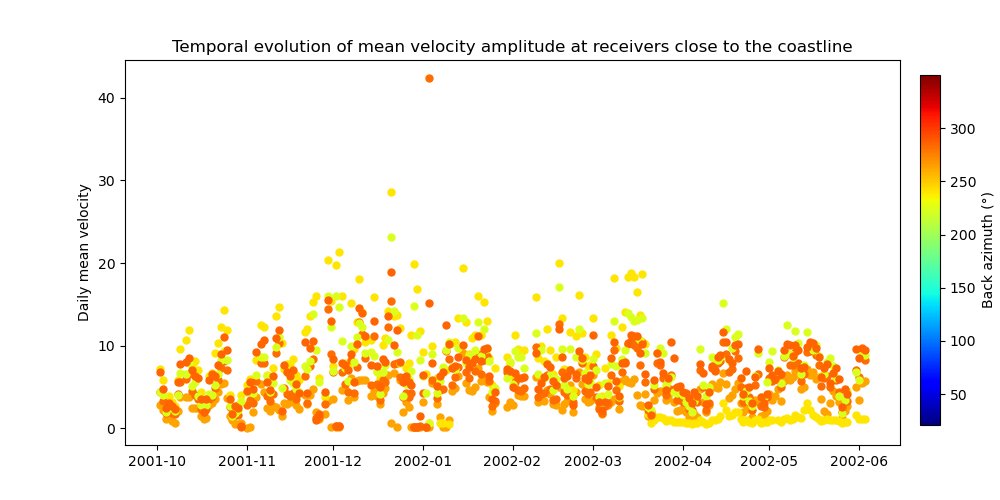

In [11]:
#load les fichiers des stations

file_path = f"{basepath}/utcdatetime_list.txt"
utcdt_list = read_utcdatetime_list_from_file(file_path=file_path)
amplitudes_list = np.load(f'{basepath}/amplitudes_list.npy')
baz_station = np.load(f'{basepath}/baz_station.npy')

# amplitudes_list[np.where(amplitudes_list<1e-8)]=np.nan #fou des nan là où l'amplitude est anormalement faible !!

#ici no peut laod les matrices avec l'amplitude et et le baz enresgitrés + les dates des beams : permetra de comparer 
time_beam = read_datetime_list_from_file(file_path='dates_range.txt') #load les temps datetime associés aux beams as well!! yey c'est important 
baz_beam = np.load('baz_matrix.npy') 
amplitudes_beam = np.load('amplitude_matrix.npy')
idx_to_remove = np.where(baz_beam==999)[1] #retire quand y'avait pas de données
baz_beam = np.delete(baz_beam[0,:], idx_to_remove, axis=0)
amplitudes_beam = np.delete(amplitudes_beam[0,:], idx_to_remove, axis=0)
indexes_to_remove = list(idx_to_remove)
indexes_to_remove.sort(reverse=True)
for index in indexes_to_remove:
    del time_beam[index]

        
################ ON CONNAIT NOW LES BAZ DES STATIONS ET LES BAZ DES MAX DES BEAMS : VA FAÇONNER L'ÉCHELLE DE COULEUR POUR POUVOIR ALLER DU MIN AU MAX !!!
color_coeff = 1/(np.max([baz_station.max(),baz_beam.max()])-np.min([baz_station.min(),baz_beam.min()]))
baz_station_normalized= color_coeff*baz_station
baz_station_normalized -= color_coeff*np.min([baz_station.min(),baz_beam.min()])
baz_beam_normalized= color_coeff*baz_beam
baz_beam_normalized -= color_coeff*np.min([baz_station.min(),baz_beam.min()])
colors_station = plt.cm.jet(baz_station_normalized)
colors_beam = plt.cm.jet(baz_beam_normalized)

###### c'est bon on a calculé la couleur à associer aux stations et aux bemas en fonction du baz, now on devrait voir si pour même baz on a des amplitudes similaires entre stations
#  mettre marker différent en focntion de station !! 


fig, ax = plt.subplots(figsize=(10,5))
for i, sta in enumerate(sta_list):
    if 200<baz_station[i]<300 : #condition sur baz station pour plot que ceux dans range souhaitée !
        ax.plot_date(utcdt_list,1e9*amplitudes_list[i,:], label=sta, c=colors_station[i,:], ms=5)
#maintenant on va plot le profil d'amplitude, dont les diverses points ont une couleur dépendant du baz as well
# for i in range(len(time_beam)):
#     ax.plot_date(time_beam[i], 0.002*amplitudes_beam[i], c=colors_beam[i,:],ms=5, marker='*')

norm = plt.Normalize(np.min([baz_station.min(), baz_beam.min()]),
                     np.max([baz_station.max(), baz_beam.max()]))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = ColorbarBase(ax=cax, cmap=cm.jet, norm=norm)
cbar.set_label('Back azimuth (°)')
ax.set_ylabel('Daily mean velocity')
ax.set_title('Temporal evolution of mean velocity amplitude at receivers close to the coastline')

### cherche le baz de la bouée pour savoir quelle station proche de la coastline on dverait choisir 
print('le baz de la bouée est', gps2dist_azimuth(35.770, -121.903, lat_bary, lon_bary)[2])

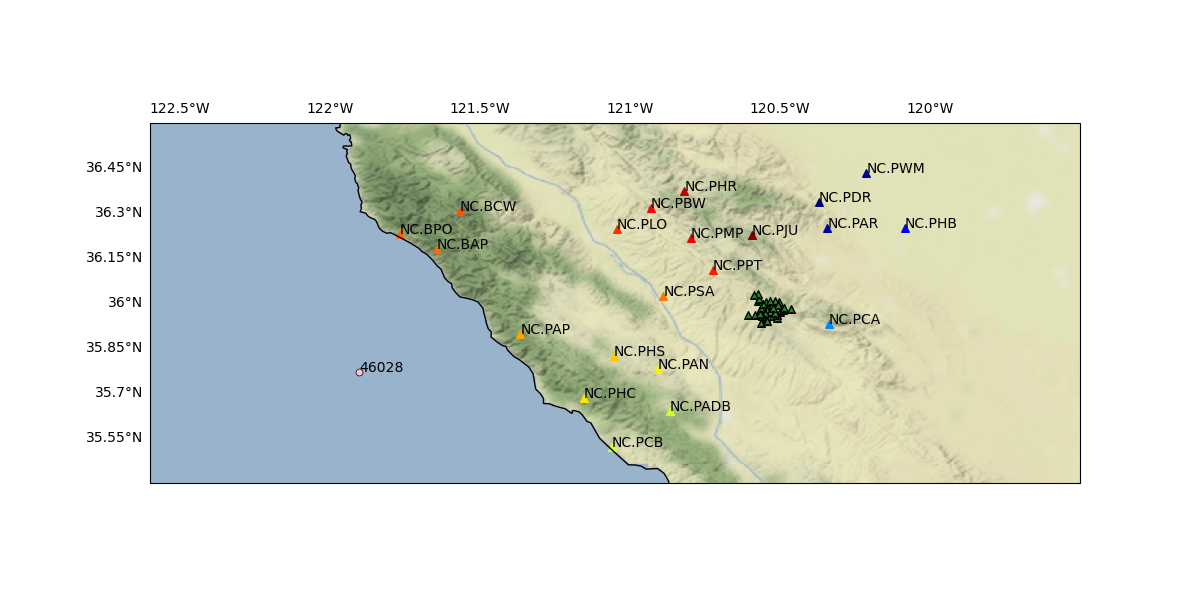

In [9]:
#on plot aussi les stations sur une carte avec same couleur que celle affichée sur le plot
lat_station = np.load(f'{basepath}/lat_station.npy')
lon_station = np.load(f'{basepath}/lon_station.npy')

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# extent = [np.min(lon_station)-1, np.max(lon_station)+1, np.min(lat_station)-1, np.max(lat_station)+1]
extent = [-122.6, -119.5, 35.4, 36.6]

ax.set_extent(extent)
stamen_terrain = Stamen(desired_tile_form="RGB", style="terrain-background") 
ax.add_image(stamen_terrain, 8)
ax.coastlines()        


for i in range(len(baz_station)):
    ax.scatter(lon_station[i], lat_station[i],c=colors_station[i,:], marker='^', transform=ccrs.PlateCarree(), s=30)
    if extent[0]<=lon_station[i]<=extent[1] and extent[2]<=lat_station[i]<=extent[3]:
        ax.text(lon_station[i], lat_station[i], f'NC.{sta_list[i]}')

lon_array, lat_array, height_array = extract_coordinates('stations_rm_nobad.txt')
ax.scatter(lon_array, lat_array,c='forestgreen', marker='^',edgecolors='black', transform=ccrs.PlateCarree(), s=30)



#rajoute aussi les coordonnées de la bouée
ax.scatter(-121.903, 35.770,c='pink', marker='.', transform=ccrs.PlateCarree(), s=100, edgecolors='black', linewidths=0.5)
ax.text(-121.903, 35.770, '46028', transform=ccrs.PlateCarree())



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='-')
gl.bottom_labels = False
gl.right_labels = False


# plt.savefig('near_coast_map.pdf',format='pdf', dpi=300, bbox_inches='tight')

In [12]:
#bon du coup en fait on va sélecitonner  2 bouées, celle à 263 et celle à ... baz  car cella dlà a une tendance en amplitude semblable à ce qui est observé sur els beams 
#on choisit donc d'exporter PAP et PHC 

#on exporte les 

write_utcdatetime_list_to_file(f'{basepath}/time_list_nearcoast.txt',utcdt_list)


for i, sta in enumerate(sta_list):
    np.save(f'{basepath}/amplitude_list_power_{sta}.npy',amplitudes_list[sta_list.index(sta),:])




In [ ]:
amplitudes_list_median = np.median(amplitudes_list, axis=0)

plt.figure(figsize=(15,5))
plt.plot_date(utcdt_list, amplitudes_list_median)
plt.title('Meaidan of the amplitude of the stations near the coastline')
plt.ylabel('Ampltude (vel)')


#mouais moyen convaincu sur le fait que l'on puisse voir quelque chose tbh !! 